In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. Linear regression

## Simple linear regression (GHV Chapters 6-9)

***Start of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

### Today

- Sample from a simple linear regression model

- Fit a simple linear regression model

- Investigate distributions of parameter estimates

- Primary reference: GHV Chapter 6

### The model

$$
y_i = a + b x_i + \epsilon_i,\qquad \epsilon_i\sim N(0, \sigma^2)\qquad \text{(indep.)}
$$

#### Generate fake parameters and fake data



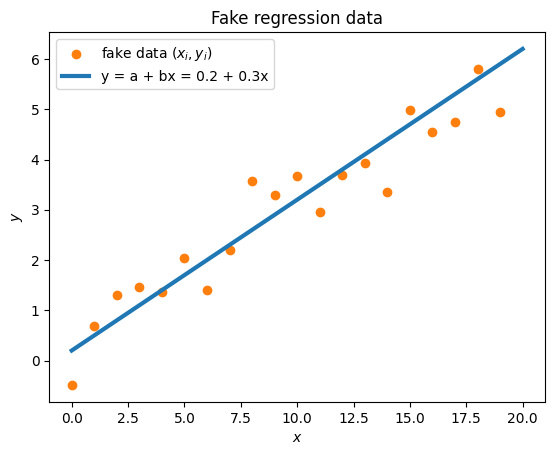

In [16]:
a = 0.2
b = 0.3
sigma = 0.5
n = 20
x = np.arange(n)
y = a + b * x + stats.norm(0, sigma).rvs(size=n)
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], lw=3, label=f"y = a + bx = {a} + {b}x")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Fake regression data")
plt.show()

#### Fit a `LinearRegression` model to the fake data

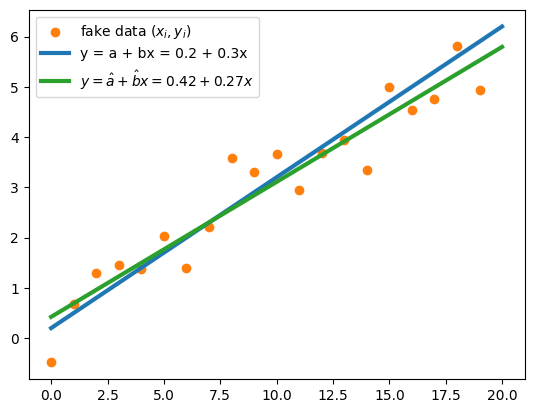

In [17]:
model = LinearRegression()
X = x.reshape(-1, 1)
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], color="C0", lw=3, label=f"y = a + bx = {a} + {b}x")
plt.plot(
    [0, 20],
    [ahat, ahat + bhat * 20],
    color="C2",
    lw=3,
    label=f"$y = \\hat{{a}} + \\hat{{b}}x = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.show()

#### Uncertainty in regression coefficients

- The coefficients estimates $\hat{a}$ and $\hat{b}$ are random variables.

- We can generate their distributions by replicating our simulation.

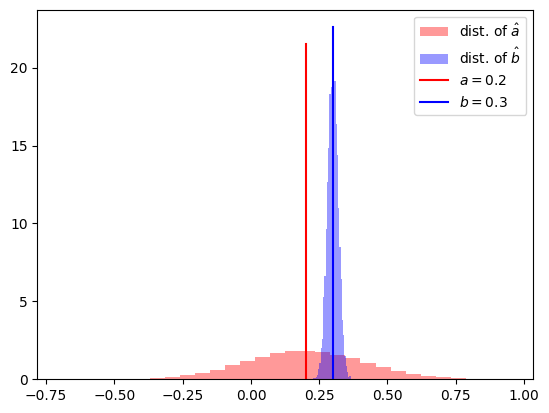

In [18]:
r = 10_000
epsilons = stats.norm(0, sigma).rvs(size=(n, r))
ys = a + b * X + epsilons
model = LinearRegression()
model.fit(X, ys)
ahats = model.intercept_
bhats = model.coef_[:, 0]
plt.hist(
    ahats, bins=30, color=(1, 0, 0, 0.4), density=True, label="dist. of $\\hat{a}$"
)
plt.hist(
    bhats, bins=30, color=(0, 0, 1, 0.4), density=True, label="dist. of $\\hat{b}$"
)
plt.plot([a, a], plt.ylim(), color=(1, 0, 0, 1), label=f"$a = {a}$")
plt.plot([b, b], plt.ylim(), color=(0, 0, 1, 1), label=f"$b = {b}$")
plt.legend()
plt.show()

- The distributions of $\hat{a}$ and $\hat{b}$ look normal because they are.

#### Residuals and estimating $\sigma$

Predicted $y$-values:
$$
\hat{y}_i = \hat{a} + \hat{b}x_i
$$

Residuals:
$$
\hat{y}_i - y_i
$$

Residual sum of squares:
$$
\operatorname{RSS} = \sum_{i < n}(\hat{y}_i - y_i)^2
$$

Estimate $\sigma^2$:
$$
s^2 = \frac{\operatorname{RSS}}{n - 2}
$$

$s$ is called the **residual standard error**.

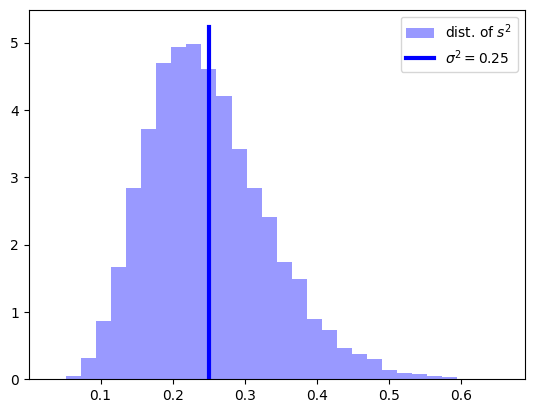

In [19]:
yhats = model.predict(X)
rsss = np.sum((yhats - ys) ** 2, axis=0)
s2s = rsss / (n - 2)
plt.hist(s2s, bins=30, density=True, color=(0, 0, 1, 0.4), label="dist. of $s^2$")
plt.plot(
    [sigma**2, sigma**2],
    plt.ylim(),
    color=(0, 0, 1),
    lw=3,
    label=f"$\\sigma^2={sigma**2}$",
)
plt.legend()
plt.show()

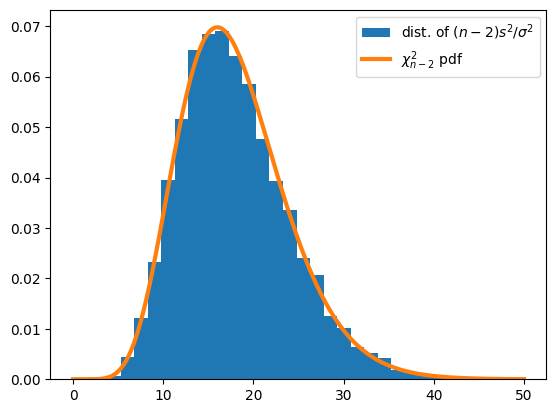

In [20]:
plt.hist(
    (n - 2) * s2s / sigma**2,
    bins=30,
    density=True,
    label="dist. of $(n-2)s^2/\\sigma^2$",
)
mesh = np.linspace(0, 50, 1000)
plt.plot(mesh, stats.chi2(n - 2).pdf(mesh), lw=3, label="$\\chi^2_{n-2}$ pdf")
plt.legend()
plt.show()

- The `LinearRegression` class doesn't compute standard errors for coefficient estimates because `scikit-learn` doesn't concern itself with statistical inference.

***End of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

***Start of Lecture 5, 2025.01.22***

### Today

- Simple linear regression examples with real data (GHV &sect;6.4, 7.1)

- *Regression to the mean* and the *regression fallacy* (GHV &sect;6.5)

- Formulating comparisons as regression models (GHV &sect;7.3)

- Primary reference: GHV Chapter 7

### Simple linear regression examples with real data

#### Heights of mothers and daughters

In [22]:
df = pd.read_csv("../data/heights.csv")

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5
...,...,...
5519,71.5,70.5
5520,73.5,63.5
5521,73.5,63.5
5522,73.5,63.5


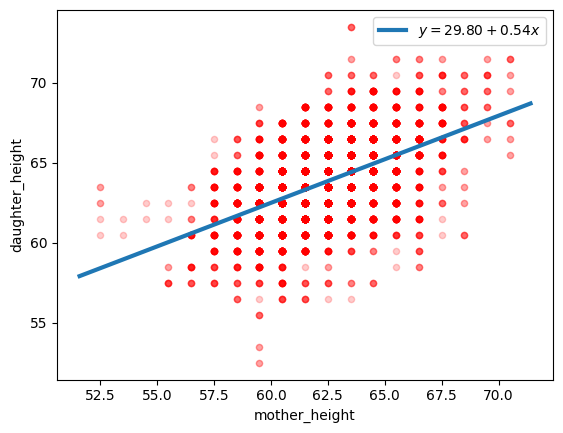

In [ ]:
X = df[["mother_height"]]
y = df["daughter_height"]

df.plot.scatter("mother_height", "daughter_height", color=(1, 0, 0, 0.2))

model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]

xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    label=f"$y = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.show()

- Interpreting the slope: Daughters of mothers with height $x + 1$ are, on average, $0.54$ inches taller than mother with height $x$.

- Since people can't be zero inches tall, the intercept's natural interpretation isn't particularly compelling in this example.


#### Regression to the mean

- Linear regression fit to mother/daughter height data:
$$
y - \underset{\bar{y}}{63.9} = \underset{\widehat{b}}{0.54}(x−\underset{\bar{x}}{62.5})
$$

- Daughters of tall (short) mothers tend to be taller (shorter) than average but shorter (taller) than their
mothers.

- From one generation to the next, heights "regress to the mean".

- The regression "paradox": Why doesn't the variability in height decrease over generations?

#### The regression fallacy

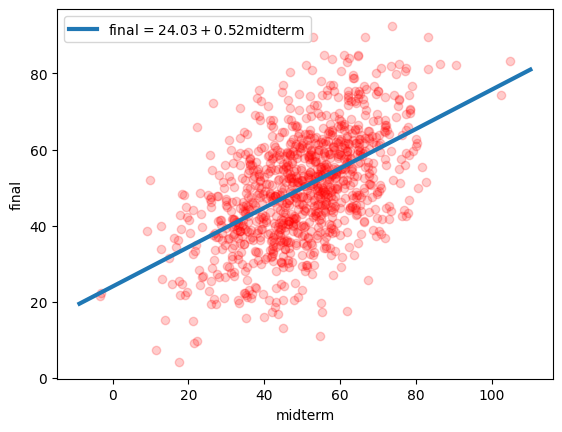

In [ ]:
n = 1000
talent = stats.norm(50, 10).rvs(n)
midterm = talent + stats.norm(0, 10).rvs(n)
final = talent + stats.norm(0, 10).rvs(n)
plt.scatter(midterm, final, color=(1, 0, 0, 0.2))
plt.xlabel("midterm")
plt.ylabel("final")
model = LinearRegression()
model.fit(midterm.reshape(-1, 1), final)
ahat = model.intercept_
bhat = model.coef_[0]

xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    label=f"$\\operatorname{{final}} = {ahat:.2f} + {bhat:.2f}\\operatorname{{midterm}}$",
)
plt.legend()
plt.show()

- The *regression fallacy* is interpreting regression to the mean causally.

- Examples:

   - Scoring highly on the midterm leads to overconfidence and underperforming on the final exam.

   - Negative reinforcement is more effective than positive reinforcement.

   - Sophomore slump. Sports Illustrated cover jinx. Madden curse. [More examples](https://en.wikipedia.org/wiki/Regression_toward_the_mean#Regression_fallacies).

#### Forecasting elections from the economy

> "[It's the economy, stupid!](https://en.wikipedia.org/wiki/It%27s_the_economy,_stupid)"
> James Carville, 1992

<img src="https://www.hup.harvard.edu/img/feeds/jackets/9780674027367.png" height="300px">

In [40]:
df = pd.read_csv("../data/hibbs.csv")
df

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon
5,1972,3.62,61.79,Nixon,McGovern
6,1976,1.08,48.95,Ford,Carter
7,1980,-0.39,44.70,Carter,Reagan
8,1984,3.86,59.17,Reagan,Mondale
9,1988,2.27,53.94,"Bush, Sr.",Dukakis


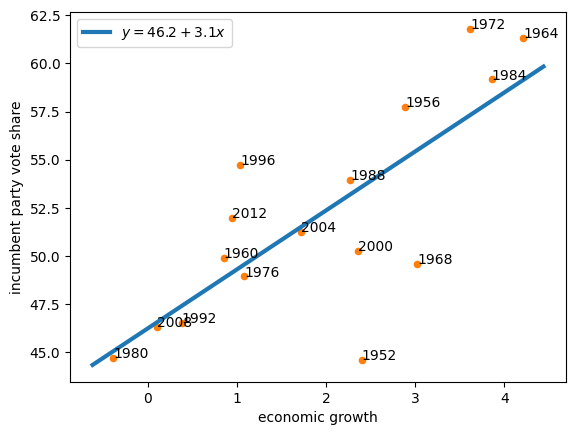

In [54]:
df.plot.scatter(
    "growth",
    "vote",
    color="C1",
    xlabel="economic growth",
    ylabel="incumbent party vote share",
)

X = df[["growth"]]
y = df["vote"]
model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]

xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    label=f"$y = {ahat:.1f} + {bhat:.1f}x$",
)

for _, row in df.iterrows():
    plt.annotate(str(row.year), (row.growth, row.vote))

plt.legend()
plt.show()

Estimate the residual standard error $\sigma$:

In [53]:
yhat = model.predict(X)
n = len(df)
s = np.sqrt(np.sum((yhat - y) ** 2) / (n - 2))
print(f"s = {s:.1f}")

s = 3.8


##### What does the model predict for the 2016 Clinton/Trump election?

- Clinton represented the incumbent Democratic party.

- Economic growth in 2016 was 2%, so $x=2$.

- Model:
$$
y\sim N(a + bx,\sigma^2)\approx N(\hat{a} + \hat{b}x, s^2)\\
$$
- Probability of Trump victory:
$$
\begin{aligned}
\mathbb{P}[y < 50] &= \operatorname{cdf}_{N(a + bx,\sigma^2)}(50)\\
&\approx \operatorname{cdf}_{N(\hat{a} + \hat{b}x, s^2)}(50)
\end{aligned}
$$

In [66]:
trumpprob = stats.norm(ahat + bhat * 2, s).cdf(50)
print(f"trumpprob = {trumpprob:.2f}")

trumpprob = 0.26


In [1]:
import bambi as bmb
import numpy as np
import pandas as pd


1

-1

:

factor(...)

y ~ .

log(earn) ~ height

log(weight) ~ log(canopy_volume)

sqrt(earnings_top) ~ male + over65 + white + immig + educ_r +

workmos + workhrs_top + any_ssi + any_welfare + any_charity

(earnings>0) ~ male + over65 + white + immig + educ_r +
any_ssi + any_welfare + any_charity

postlet ~ watched_hat_3 + prelet + as.factor(site) + setting

cbind(y, n-y) ~ x



In [70]:
x = np.array(3)

# getattr(np, "exp")(3)

numpy.ndarray

In [89]:
import sys


def f(x: int):
    if x > 5:
        import numpy as backend
    else:
        import pytensor as backend
    return backend


ufuncs = [s for s in dir(np) if isinstance(getattr(np, s), np.ufunc)]
ufuncs

['abs',
 'absolute',
 'add',
 'arccos',
 'arccosh',
 'arcsin',
 'arcsinh',
 'arctan',
 'arctan2',
 'arctanh',
 'bitwise_and',
 'bitwise_not',
 'bitwise_or',
 'bitwise_xor',
 'cbrt',
 'ceil',
 'conj',
 'conjugate',
 'copysign',
 'cos',
 'cosh',
 'deg2rad',
 'degrees',
 'divide',
 'divmod',
 'equal',
 'exp',
 'exp2',
 'expm1',
 'fabs',
 'float_power',
 'floor',
 'floor_divide',
 'fmax',
 'fmin',
 'fmod',
 'frexp',
 'gcd',
 'greater',
 'greater_equal',
 'heaviside',
 'hypot',
 'invert',
 'isfinite',
 'isinf',
 'isnan',
 'isnat',
 'lcm',
 'ldexp',
 'left_shift',
 'less',
 'less_equal',
 'log',
 'log10',
 'log1p',
 'log2',
 'logaddexp',
 'logaddexp2',
 'logical_and',
 'logical_not',
 'logical_or',
 'logical_xor',
 'matmul',
 'maximum',
 'minimum',
 'mod',
 'modf',
 'multiply',
 'negative',
 'nextafter',
 'not_equal',
 'positive',
 'power',
 'rad2deg',
 'radians',
 'reciprocal',
 'remainder',
 'right_shift',
 'rint',
 'sign',
 'signbit',
 'sin',
 'sinh',
 'spacing',
 'sqrt',
 'square',
 'sub

In [145]:
import numpy as np
import pandas as pd
import re
from dataclasses import dataclass
from typing import Collection


@dataclass(frozen=True)
class Formula:
    string: str
    response: str
    predictors: Collection[str]
    fit_intercept: bool


def parse_formula(string: str):
    sides = string.split("~")
    assert len(sides) > 0
    if len(sides) == 1:
        assert "~" not in string
        raise SyntaxError("Formula must contain the ~ character.")
    if len(sides) > 2:
        assert len(re.findall(string, "~")) > 1
        raise SyntaxError("Formula can only contain a single ~ character.")

    response = sides[0].strip()
    if response == "":
        raise SyntaxError("Left-hand-side cannot be empty.")

    predictors = []
    wildcard = False
    fit_intercept = None
    lhs_terms = [term.strip() for term in sides[1].split("+")]
    for term in lhs_terms:
        if term == "":
            raise SyntaxError("Empty term")
        elif term == "1":
            if fit_intercept is not None:
                raise SyntaxError("Multiple intercept terms.")
            fit_intercept = True
        elif term == "-1" or term == "0":
            if fit_intercept is not None:
                raise SyntaxError("Multiple intercept terms.")
            fit_intercept = False
        elif term == ".":
            if wildcard:
                raise SyntaxError("Multiple uses of wildcard '.'")
            if predictors != []:
                raise SyntaxError(
                    f"Wildcard '.' in the presence of another predictor ({predictors[0]})."
                )
            wildcard = True

        else:
            if wildcard:
                raise SyntaxError(
                    f"Wildcard '.' in the presence of another predictor ({term})."
                )
            elif term in predictors:
                raise SyntaxError(f"Repeated term: {term}")
            else:
                predictors.append(term)
    if fit_intercept is None:
        fit_intercept = True
    return Formula(
        string=string,
        response=response,
        predictors=predictors,
        fit_intercept=fit_intercept,
    )


parse_formula("y ~ y +  x + sdf")

Formula(string='y ~ y +  x + sdf', response='y', predictors=['y', 'x', 'sdf'], fit_intercept=True)

In [146]:
import bambi as bmb
import arviz as az

df = pd.read_csv("../data/hibbs.csv")

# Initialize the fixed effects only model
model = bmb.Model("vote ~ growth", df)
results = model.fit(draws=1000)
az.summary(results)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, growth]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,4.032,0.816,2.643,5.518,0.017,0.012,2534.0,2562.0,1.0
Intercept,46.312,1.763,43.103,49.654,0.027,0.019,4293.0,3045.0,1.0
growth,3.025,0.761,1.556,4.438,0.012,0.009,4102.0,2639.0,1.0


In [ ]:
fit_intercept = np.array(results.posterior.Intercept).ravel()
growth = np.array(results.posterior.growth).ravel()
sigma = np.array(results.posterior.sigma).ravel()
vote = fit_intercept + growth * 2 + stats.norm().rvs(4000) * sigma

0.7175


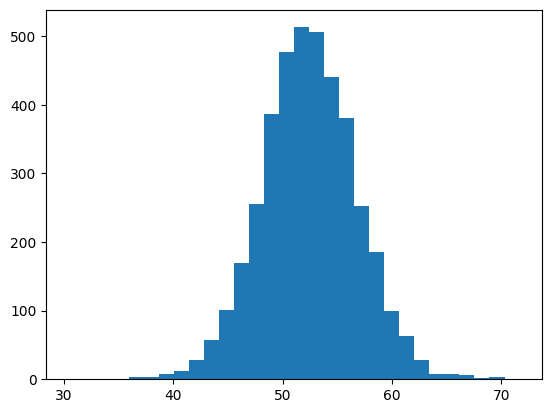

In [34]:
print(np.mean(vote > 50))
plt.hist(vote, bins=30)
plt.show()

In [35]:
results

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [37]:
data = pd.DataFrame({"growth": [2.0]})
model.predict(results, kind="response", data=data)

In [41]:
y = np.array(results.posterior_predictive.vote).ravel()
y.shape

(4000,)

In [43]:
np.mean(y > 50)

0.719

In [166]:
from sklearn.datasets import load_diabetes
from numpy.typing import ArrayLike
from typing import cast, Any

X, y = load_diabetes(return_X_y=True)
X = cast(np.ndarray[Any, np.dtype[np.floating]], X)
np.linalg.qr(X)

QRResult(Q=array([[-0.03807591,  0.04474541, -0.05310932, ..., -0.03074582,
         0.03143588, -0.04794526],
       [ 0.00188202, -0.044999  ,  0.04950345, ...,  0.06933564,
        -0.05436726, -0.07274162],
       [-0.08529891,  0.03641432, -0.02710576, ..., -0.00435802,
         0.02326707, -0.05296417],
       ...,
       [-0.04170844,  0.04410455,  0.0266382 , ..., -0.02198975,
        -0.04517943,  0.02449647],
       [ 0.04547248, -0.03730877, -0.05055693, ..., -0.01241972,
         0.03704488, -0.04408923],
       [ 0.04547248, -0.03730877,  0.06369772, ...,  0.12171224,
         0.0723075 ,  0.03943857]]), R=array([[-1.        , -0.1737371 , -0.18508467, -0.33542759, -0.26006082,
        -0.21924314,  0.07518097, -0.2038409 , -0.27077424, -0.30173101],
       [ 0.        ,  0.98479207,  0.0568702 ,  0.1855562 , -0.01005836,
         0.10616108, -0.37168039,  0.30128225,  0.10446124,  0.15811596],
       [ 0.        ,  0.        , -0.98107566, -0.32900192, -0.2061168 ,
      

In [171]:
from typing import Any
from numpy.typing import NDArray


def f(X: NDArray[np.floating]):
    qr_result = np.linalg.qr(X)


X = np.random.normal(size=[5, 5])
qr_result = np.linalg.qr(X)
isinstance(qr_result, tuple)
Q = qr_result.Q
R = qr_result.R

np.allclose(Q @ R, X)

True

In [153]:
a = np.random.randn(9, 6)
Q, R = np.linalg.qr(a)

In [ ]:
X